In [45]:
from Basefolder import basefolder
import time
import numpy as np
import pandas as pd
from Finder_1d import Finder_1d
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import seaborn as sns
from sklearn.cluster import DBSCAN
from Clustering_CAML import Clustering_CAML
import h5py
from DbscanLoop import DbscanLoop
from sklearn.neighbors import NearestNeighbors
import pickle
import scipy.stats as stats
import json
import os.path

from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotScatter
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import LoadPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import FilterPoints
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetLineOfOptimaUnique
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterDistribution
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import GetClusterSizesAlongOptima
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import AnalyseClusterSizes
from FigX4_Explore2DOptimizer_withReference_Streamlined_Functions import PlotDistribution

pd.options.mode.chained_assignment = None  # default='warn'

In [46]:
basefolder = '/Users/andreas/Documents/NoiseRecognizer_WorkingVersion/';

### Possible parameter sets

In [47]:
parameters_TTX = {'mainfolder'    :'ProteinData_ttx_1hr_2/',\
                  'image_filename':'AHA_2_MMStack_Pos0.ome_locs_render_driftcor_filter_render_pix0.02X6f20_X',\
                  'signal_window' :[40000,45000,40000,45000],\
                  'noise_window'  :[50000,60000,40000,50000],\
                  'datascale'     :158,
                  'algo'          :'DbscanLoop',\
                  'analysis_name' :'dataWindow_5'};

parameters_Mike = {'mainfolder'    :'MikeData/',\
                   'image_filename' :'EGFR-P1-ATTO655_cell_2_MMImages.ome_locs_render_al_linked1sigma_X',\
                   'signal_window'  :[50,60,50,60],\
                   'noise_window'   :[50,100,100,150],\
                   'algo'           :'DbscanLoop',\
                   'analysis_name'  :'dataWindow_1'};

# Parameters

In [48]:
loadSaveParameters = 'load';

In [49]:
if(loadSaveParameters=='load'):
    parameterfile = 'ProteinData_ttx_1hr_2/Analysis_dataWindow_3/dataWindow_3_parameters';
#    parameterfile = 'MikeData/Analysis_dataWindow_1/dataWindow_1_parameters';    
    
    
    with open(basefolder+parameterfile+'.json') as f:
        parameters = json.load(f);
        
    if(not ('datascale' in parameters.keys())):
        parameters['datascale'] = 1;
    
elif(loadSaveParameters=='save'):
    
    parameters                   = parameters_TTX;    
    parameters['outputfolder']   = parameters['mainfolder'] + 'Analysis_'+parameters['analysis_name']+'/';    
    parameters['save_name']      = parameters['outputfolder']+parameters['analysis_name'];
    
    parameterfile   = basefolder+parameters['save_name']+'_parameters.json';
        
    if(os.path.isfile(parameterfile)):
        
        with open(parameterfile) as f:
            parameters_read = json.load(f)
        
        if(parameters_read == parameters):
            print('File exists with equal parameters');
        else:
            print('File exists with different parameters. File not saved.');
    else:
        
        if not os.path.exists((basefolder+parameters['outputfolder'])):
            os.makedirs((basefolder+parameters['outputfolder']))
                
        with open(parameterfile, 'w') as fp:
            json.dump(parameters, fp, indent=4);
            
        print("Parameters saved under "+parameterfile);
else:
    print("ERROR: Choose load or save");

In [50]:
save_name = basefolder + parameters['save_name'];

# Load Points

In [51]:
XC_signal = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_signal.txt',datascale=parameters['datascale']);    
XC_noise  = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_noise.txt',datascale=parameters['datascale']);    

In [52]:
#XC_signal = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_signal.txt',datascale=158);    
#XC_noise  = LoadPoints(basefolder+parameters['mainfolder']+parameters['image_filename']+'_noise.txt',datascale=158);    

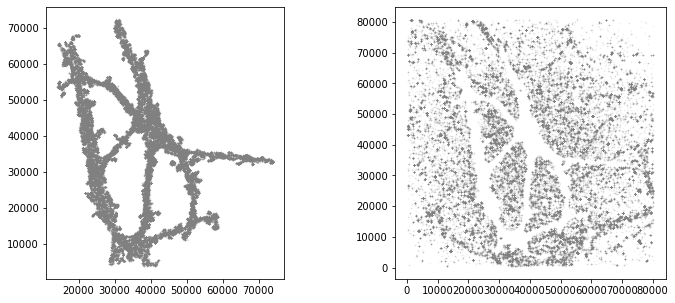

In [53]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal[:,:],ax=axs[0])
PlotScatter(XC_noise[:,:],ax=axs[1])

In [54]:
XC_signal = FilterPoints(XC_signal,parameters['signal_window']);
np.savetxt(basefolder+parameters['save_name']+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");   

XC_noise  = FilterPoints(XC_noise,parameters['noise_window']);
np.savetxt(basefolder+parameters['save_name']+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");

Plot Overview

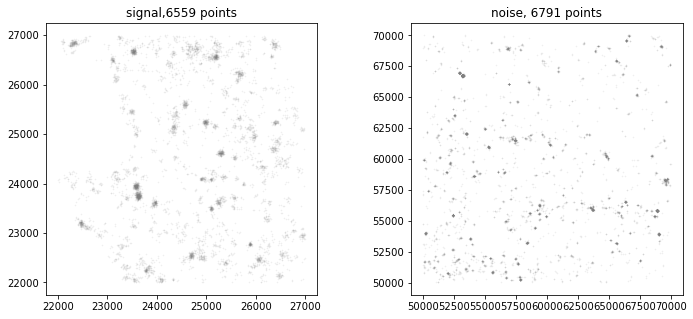

In [55]:
fig,axs = plt.subplots(1,2,figsize=(12,5));
PlotScatter(XC_signal,ax=axs[0])
PlotScatter(XC_noise,ax=axs[1])
#np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    
axs[0].set_title('signal,'+str(len(XC_signal))+' points');
axs[1].set_title('noise, '+str(len(XC_noise))+' points');
for ax in axs:
    ax.set_aspect('equal');
#axs[1].set_xlim([50,60]);
#axs[1].set_ylim([50,60]);
plt.savefig(basefolder+parameters['save_name']+"_localizations_signal_vs_noise.pdf",bbox_inches="tight");

# Load or compute clustering

In [12]:
#labels_ref  = FD_ref.fit(XC_noise,XC_signal,skipSimilarityScore=True);

In [13]:
loadComputeClustering = "load";

In [14]:
filename = basefolder+parameters['outputfolder']+"results_"+parameters['analysis_name'];
if(loadComputeClustering == "compute"):
    FD      = Finder_1d(algo=parameters['algo']);
    labels  = FD.fit(XC_signal);    
    
    with open(filename+'_signal.pickle','wb') as handle:
        pickle.dump({'FD':FD}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
    
    FD_ref      = Finder_1d(algo=parameters['algo']);
    labels_ref  = FD_ref.fit(XC_noise,XC_signal,skipSimilarityScore=True );    
    
    with open(filename+'_noise.pickle','wb') as handle:
        pickle.dump({'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
    
    if(os.path.exists(filename+'.pickle')):
        os.remove(filename+'.pickle');
    #with open(filename+'.pickle','wb') as handle:
    #    pickle.dump({'FD':FD,'FD_ref':FD_ref}, handle,protocol=pickle.HIGHEST_PROTOCOL)   
elif(loadComputeClustering == "load"):
    
    if(os.path.exists(filename+'.pickle')):
        with open(filename+'.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);

        FD     = FD_load['FD'];
        FD_ref = FD_load['FD_ref'];
    else:
        with open(filename+'_signal.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);
        FD     = FD_load['FD'];        

        with open(filename+'_noise.pickle', 'rb') as fr:
            FD_load = pickle.load(fr);        
        FD_ref     = FD_load['FD_ref'];
    
    print("Loaded Clustering results from "+filename+'.pickle');
else:
    print("ERROR");

Loaded Clustering results from /Users/andreas/Documents/NoiseRecognizer_WorkingVersion/MikeData/Analysis_dataWindow_1/results_dataWindow_1.pickle


In [15]:
df1     = FD.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];
df1_ref = FD_ref.phasespace[['sigma', 'threshold','similarityScore','no_clusters']];

df1['similarityScore_ref']       = df1_ref['similarityScore'];
df1['similarityScore_ref_ratio'] = (df1_ref['similarityScore'])/(df1['similarityScore']);

df1['no_clusters_ref']       = df1_ref['no_clusters'];
df1['no_clusters_ref_ratio'] = (df1_ref['no_clusters'])/(df1['no_clusters']);

df_opt_sim = GetLineOfOptima(df1,'similarityScore_ref','similarityScore',15);
df_opt_cl  = GetLineOfOptima(df1,'no_clusters_ref','no_clusters',15);

# Analysis
## Heatmaps Similiarity Score and Number of Clusters

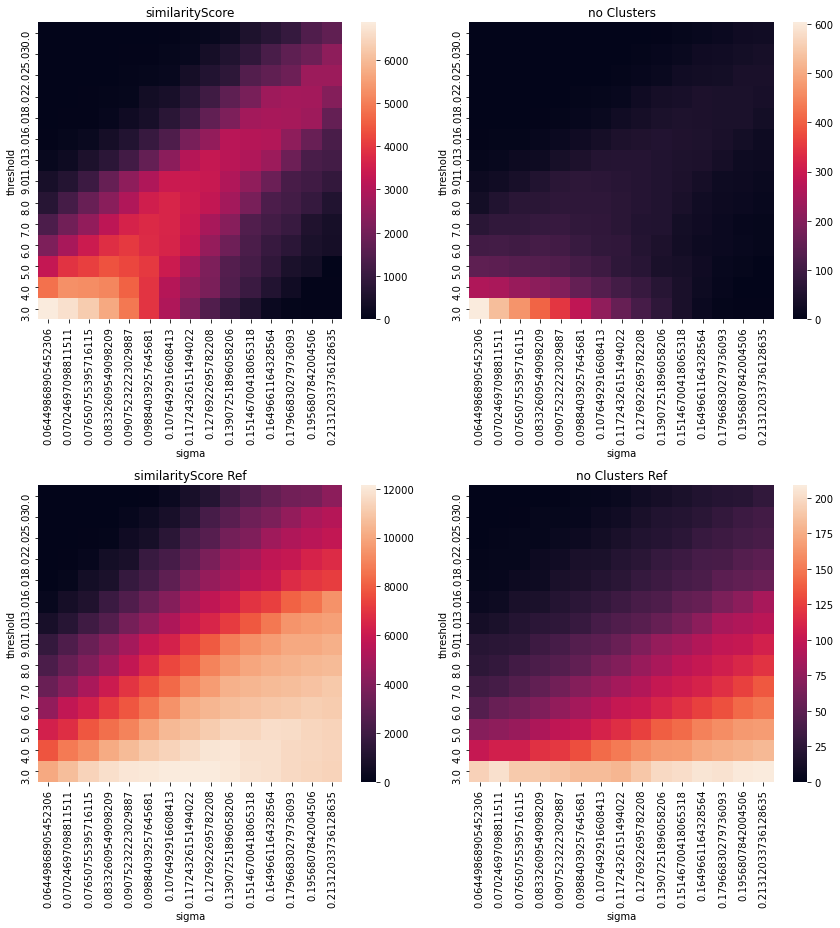

In [16]:
fig,axs = plt.subplots(2,2,figsize=(12,13));


heatmap1_data = pd.pivot_table(df1, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,0]);
ax.invert_yaxis()
ax.set_title('similarityScore');

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0,1]);
ax.invert_yaxis()
ax.set_title('no Clusters');

heatmap1_data = pd.pivot_table(df1_ref, values='similarityScore', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,0]);
ax.invert_yaxis()
ax.set_title('similarityScore Ref');

heatmap1_data = pd.pivot_table(df1_ref, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1,1]);
ax.invert_yaxis()
ax.set_title('no Clusters Ref');

fig.tight_layout();
plt.savefig(save_name+"_PhaseSpaces.pdf",bbox_inches="tight");

## Analyse Line Of Optima of signal

In [17]:
a = FD.phasespace.loc[2,'labels']
aa = np.array([[x,np.sum(a==x)] for x in set(a)])

In [18]:
df_clusterSizes

NameError: name 'df_clusterSizes' is not defined

In [19]:
df_opt_th     = GetLineOfOptima(df1,'threshold','similarityScore')
df_opt_th_ncl = GetLineOfOptima(df1,'threshold','no_clusters')

df_clusterSizes     = GetClusterSizesAlongOptima(FD,df_opt_th);
df_clusterSizes_ref = GetClusterSizesAlongOptima(FD_ref,df_opt_th);

df_clusterSizes['type'] = 'signal';
df_clusterSizes_ref['type'] = 'noise';
df_clusterSizes_all = df_clusterSizes.append(df_clusterSizes_ref, ignore_index=True);

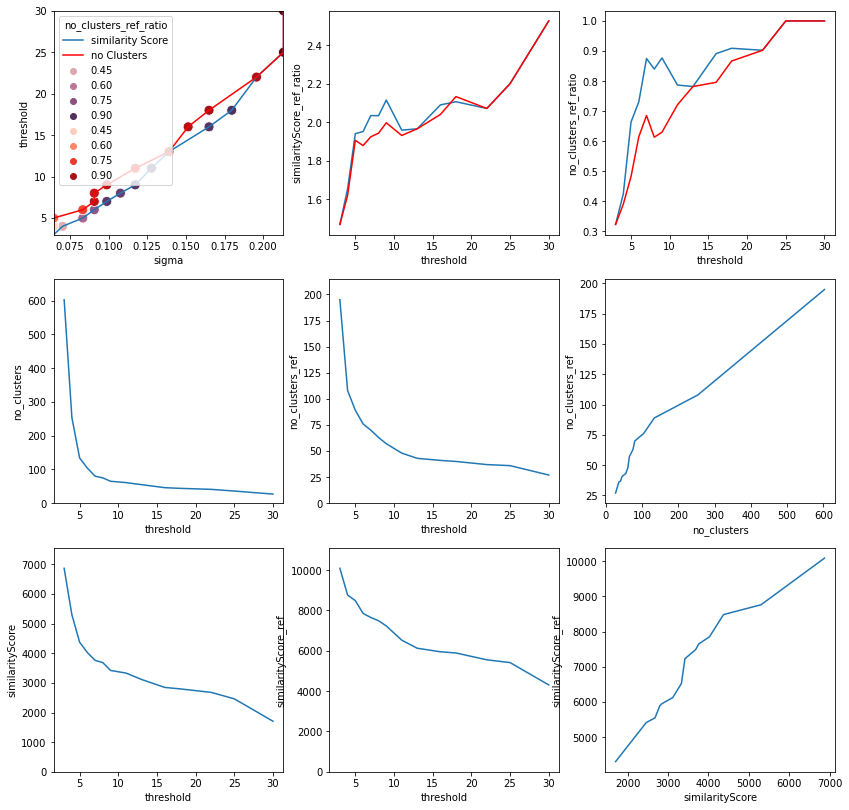

In [20]:
fig,axs = plt.subplots(3,3,figsize=(14,14));

ax = axs[0,0];
ax.plot(df_opt_th['sigma'],df_opt_th['threshold'],label='similarity Score');
sns.scatterplot(x=df_opt_th['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],s=100,ax=ax);

ax.plot(df_opt_th_ncl['sigma'],df_opt_th_ncl['threshold'],'r',label='no Clusters');
sns.scatterplot(x=df_opt_th_ncl['sigma'],y=df_opt_th['threshold'],hue=df_opt_th['no_clusters_ref_ratio'],\
                s=100,ax=ax,palette='Reds');

ax.set_xlim(np.min(df1['sigma']),np.max(df1['sigma']))
ax.set_ylim(np.min(df1['threshold']),np.max(df1['threshold']))

ax = axs[0,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='similarityScore_ref_ratio',ax=ax,color='r');

ax = axs[0,2];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref_ratio',ax=ax);
sns.lineplot(data=df_opt_th_ncl,x='threshold',y='no_clusters_ref_ratio',ax=ax,color='r');

ax = axs[1,0];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters']));

ax = axs[1,1];
sns.lineplot(data=df_opt_th,x='threshold',y='no_clusters_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['no_clusters_ref']));

ax = axs[1,2];
sns.lineplot(data=df_opt_th,x='no_clusters',y='no_clusters_ref',ax=ax);

ax = axs[2,0];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore']));

ax = axs[2,1];
sns.lineplot(data=df_opt_th,x='threshold',y='similarityScore_ref',ax=ax);
ax.set_ylim(0,1.1*np.max(df_opt_th['similarityScore_ref']));

ax = axs[2,2];
sns.lineplot(data=df_opt_th,x='similarityScore',y='similarityScore_ref',ax=ax);

plt.savefig(save_name+"_Analysis_alongLineOfOptima.pdf",bbox_inches="tight");

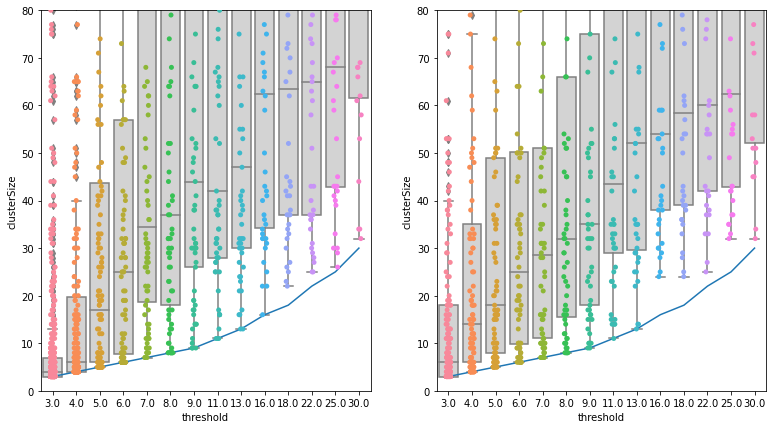

In [21]:
PlotDistribution(df_clusterSizes,df_clusterSizes_ref,save_name+"_clusterDistribution_alongLineOfOptima_signal.pdf");

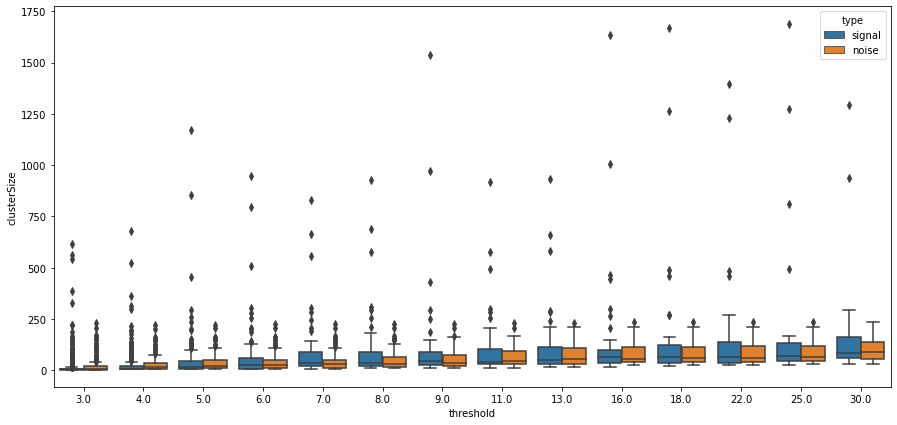

In [22]:
fig,axs = plt.subplots(1,1,figsize=(15,7));
sns.boxplot(data=df_clusterSizes_all,y='clusterSize',x='threshold',hue='type');

## Exploration

In [41]:
def GetOptimalT(df_clusterSizes_all,threshold):
    df_signal = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)&\
                    (df_clusterSizes_all['type']=='signal')];
    df_noise  = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)&\
                    (df_clusterSizes_all['type']=='noise')];
    #ts = np.linspace(10,df_signal['clusterSize'].max(),500);
    ts = [];
    signal_vs_noise_probability = [];
    for t in np.unique(df_signal['clusterSize']):
        no_clusters_over_t_noise  = np.sum(df_noise['clusterSize']>t)/len(df_noise['clusterSize']);
        no_clusters_over_t_signal = np.sum(df_signal['clusterSize']>t)/len(df_signal['clusterSize']);
        if(no_clusters_over_t_signal+no_clusters_over_t_noise > 0):
            signal_vs_noise_probability.append(no_clusters_over_t_signal/(no_clusters_over_t_noise+no_clusters_over_t_signal));
            ts.append(t);

    T = ts[np.argmax(signal_vs_noise_probability)];
    #plt.plot(ts,signal_vs_noise_probability);
    #print(signal_vs_noise_probability);
    #print(ts);    
    #print(T);
    return T;

In [42]:
GetOptimalT(df_clusterSizes_all,5)

235

In [43]:
def RemoveLabelsSmallerT(labels_input,df,T):
    #labels_signal = FD.phasespace.loc[idx_,'labels'];
    labels           = labels_input.copy();
    labels_to_remove = df.loc[df['clusterSize']<T,'labels'];
    for l in np.unique(labels_to_remove):
        labels[labels == l] = -1;
    return labels;
    
def FindAndPlot(T,threshold,df_clusterSizes_all,df_opt_th):
    #
    df_signal = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)*\
                    (df_clusterSizes_all['type']=='signal')];
    df_noise  = df_clusterSizes_all[(df_clusterSizes_all['threshold']==threshold)*\
                    (df_clusterSizes_all['type']=='noise')];
    
    T = GetOptimalT(df_clusterSizes_all,threshold);
    #*******************************************************
    # Get labels of clusters larger than T
    idx_ = int(df_opt_th.loc[df_opt_th['threshold']==threshold,'idx'])
    labels_signal = RemoveLabelsSmallerT(FD.phasespace.loc[idx_,'labels'],df_signal,T);
    labels_noise  = RemoveLabelsSmallerT(FD_ref.phasespace.loc[idx_,'labels'],df_noise,T);        
    #*******************************************************
    
    fig,axs = plt.subplots(1,2,figsize=(13,8)); 
    PlotScatter(XC_signal,labels_signal,ax=axs[0])
    PlotScatter(XC_noise,labels_noise,ax=axs[1])
    axs[0].set_title('signal for clusters with size > '+str(T));
    axs[1].set_title('noise for clusters with size > '+str(T));
    
    #axs[1].set_ylim([57500,62500]);
    #axs[1].set_xlim([55000,60000]);
    plt.savefig(save_name+"_OptimalClustering_split_threshold_"+str(threshold)+".pdf",bbox_inches="tight");

/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andreas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/Users/andre

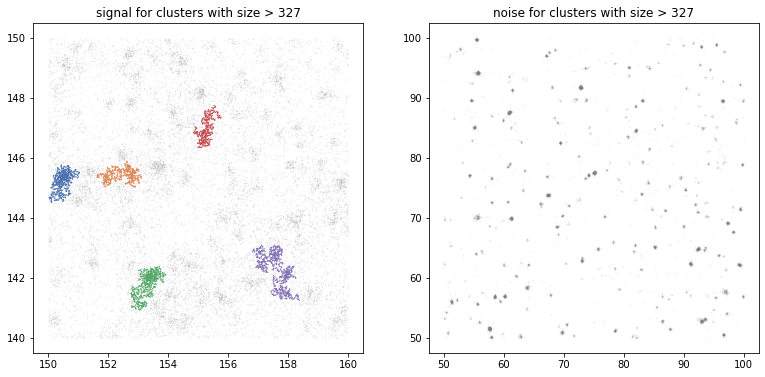

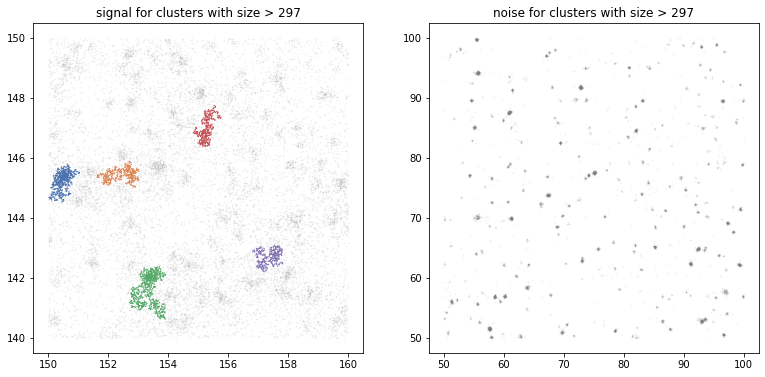

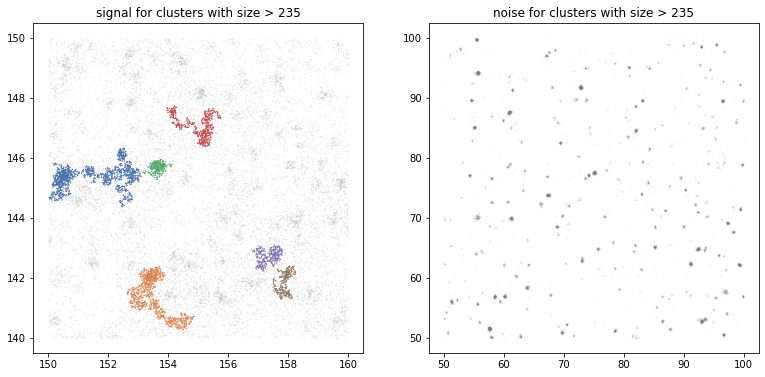

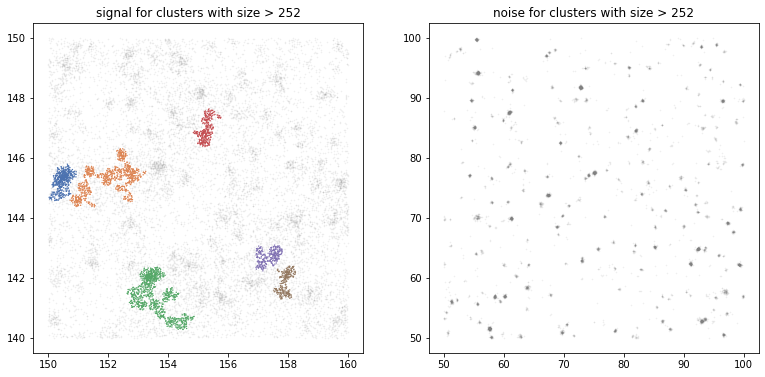

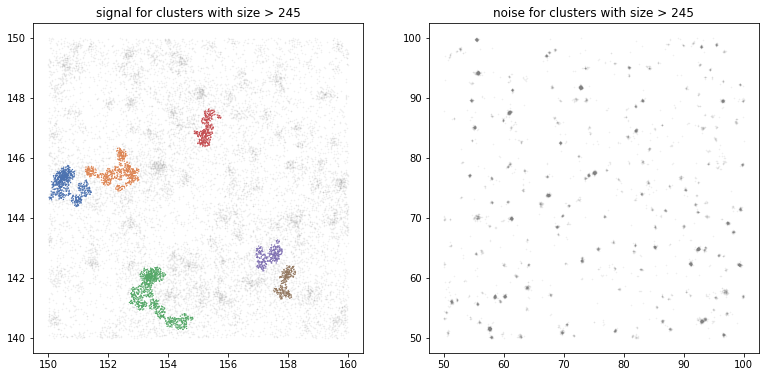

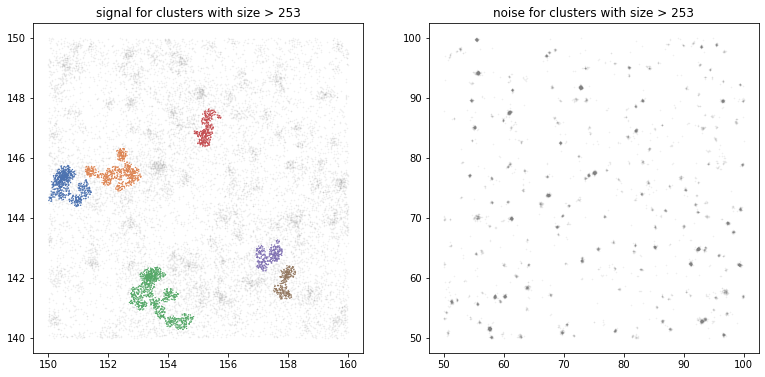

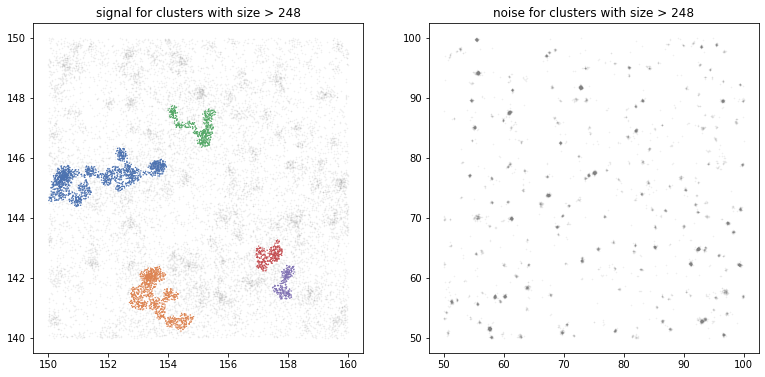

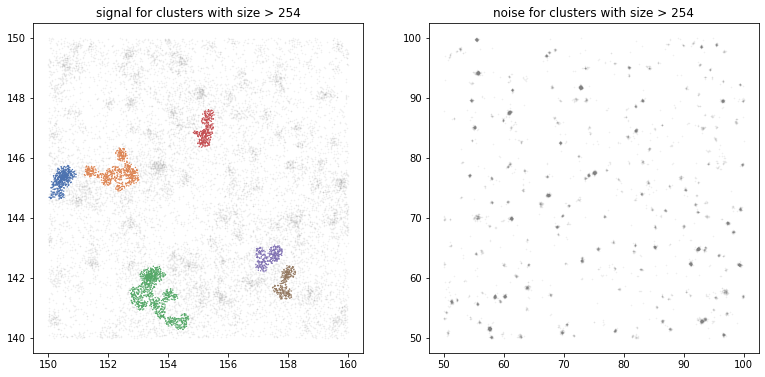

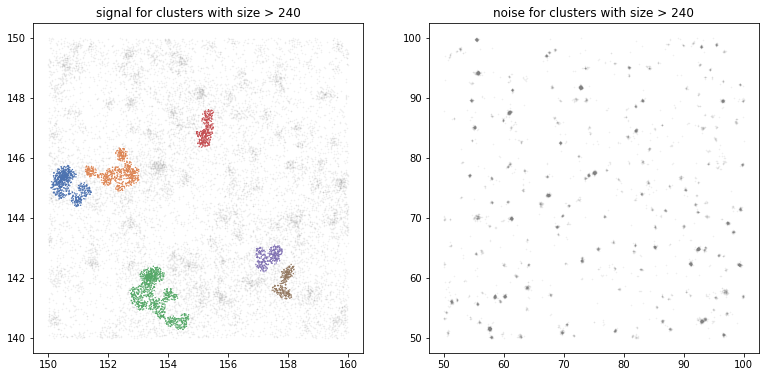

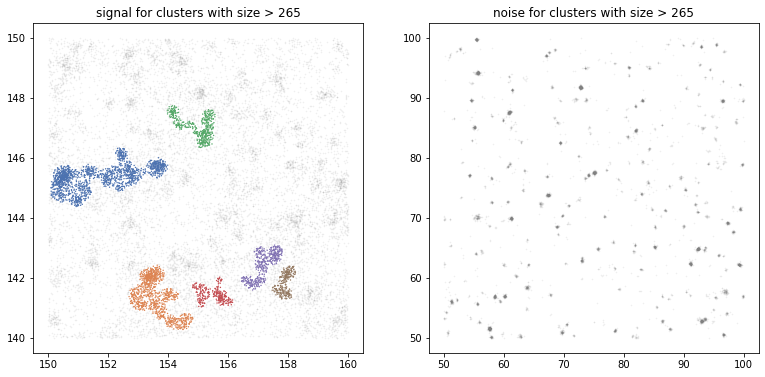

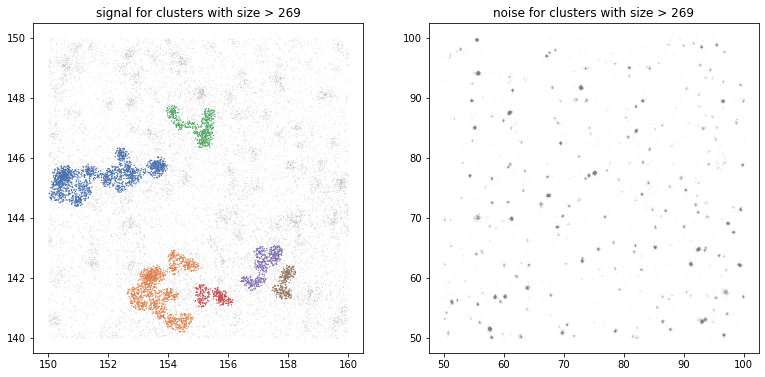

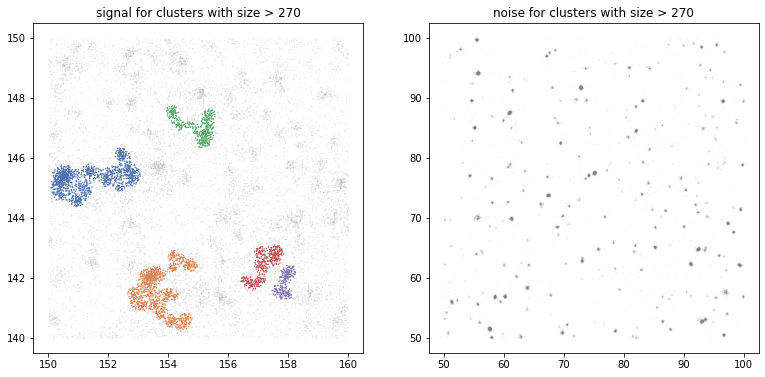

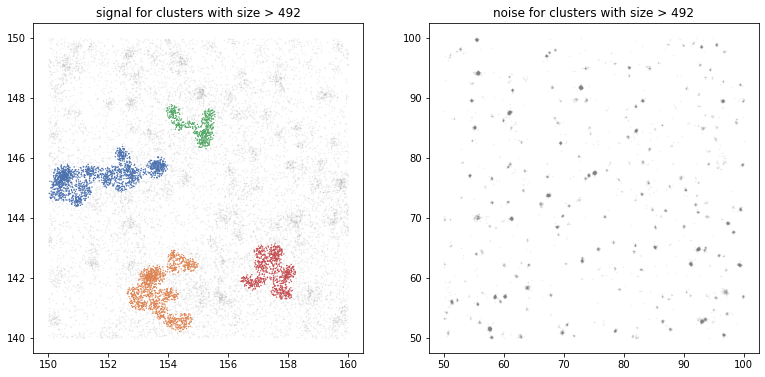

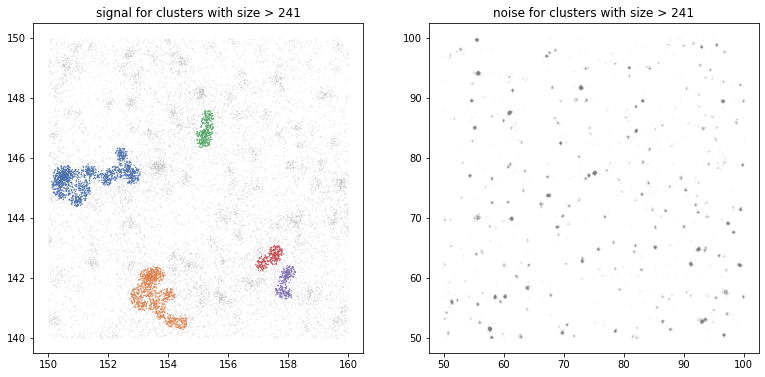

In [44]:
for th in np.unique(df_opt_th['threshold']):
    FindAndPlot(100,th,df_clusterSizes_all,df_opt_th)

In [ ]:
sns.displot(data=df_clusterSizes_all[df_clusterSizes_all['threshold']==11], x="clusterSize",hue='type')

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import nbinom

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)
    
def fit_function_nb(k,n,p):
    '''poisson function, parameter lamb is the fit parameter'''
    return nbinom.pmf(k, n,p)
    
    
def GetPoissonParameters(data):
    # the bins should be of integer width, because poisson is an integer distribution
    bins = np.round(np.linspace(0,100,20));#np.arange(100) - 0.5
    entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data');

    # calculate bin centres
    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # fit with curve_fit
    parameters, cov_matrix = curve_fit(fit_function_nb, bin_middles, entries)
    return parameters;

In [ ]:
x_plot = np.arange(600)
np.sum(x_plot*fit_function_nb(x_plot,r,1-p))


In [ ]:
data_max = 200;

mark = (df_clusterSizes_all['threshold']==11)*(df_clusterSizes_all['type']=='noise')
data = np.array(df_clusterSizes_all.loc[mark,'clusterSize'])

data = data[data < data_max]

E,V = np.mean(data),np.var(data);
r = E**2/(V-E);
p = 1-E/V;

print('r :',r,' p: ',p);

# plot poisson-deviation with fitted parameter
bins = np.round(np.linspace(1,data_max,20));#np.arange(100) - 0.5
x_plot = np.round(np.linspace(1,data_max,20));#np.arange(100);

plt.hist(data, bins=bins, density=True, label='Data');
plt.plot(
    x_plot,
    fit_function_nb(x_plot,r,1-p),
    marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()

In [ ]:
# the bins should be of integer width, because poisson is an integer distribution
bins = np.round(np.linspace(1,100,20));#np.arange(100) - 0.5
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True, label='Data');

# calculate bin centres
bin_middles = np.round(0.5 * (bin_edges[1:] + bin_edges[:-1]))

# fit with curve_fit
parameters, cov_matrix = curve_fit(fit_function_nb, bin_middles, entries)

In [ ]:
cov_matrix

In [ ]:
data

bins = np.linspace(0,100,20);
entries, bin_edges, patches = plt.hist(data, bins=bins, density=True);



In [ ]:
# get poisson deviated random numbers
#data = np.random.poisson(2, 1000)
mark = (df_clusterSizes_all['threshold']==11)*(df_clusterSizes_all['type']=='signal')
data = np.array(df_clusterSizes_all.loc[mark,'clusterSize'])
parameters = GetPoissonParameters(data)
print(parameters)

# plot poisson-deviation with fitted parameter
x_plot = np.round(np.linspace(1,100,20));#np.arange(100);

plt.plot(
    x_plot,
    fit_function_nb(x_plot,10,0.3),
    marker='o', linestyle='',
    label='Fit result',
)
plt.legend()
plt.show()

In [ ]:
df_clusterSizes_all.query('clusterSize < 100')

In [ ]:
df_clusterSizes_all.query('clusterSize < 100').groupby(by=['threshold','type']).agg(['mean','std'])

In [ ]:
df_clusterSizes_all

In [ ]:
(df_clusterSizes['type']).unique()

In [ ]:
df_stats_per_th = AnalyseClusterSizes(df_clusterSizes,df_clusterSizes_ref,save_name+"_phasespace_alongLineOfOptima.pdf");

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(data=df_stats_per_th,x='threshold',y='quantile_90',hue='type',ax=axs[0]);
sns.lineplot(data=df_stats_per_th,x='threshold',y='n',hue='type',ax=axs[1]);

In [ ]:
for th in np.unique(df_opt_th['threshold']):
    idx_ = int(df_opt_th.loc[df_opt_th['threshold']==th,'idx'])

    fig,axs = plt.subplots(1,2,figsize=(13,8)); 
    PlotScatter(XC_signal,FD.phasespace.loc[idx_,'labels'],ax=axs[0])
    PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_,'labels'],ax=axs[1])
    axs[0].set_title('signal');
    axs[1].set_title('noise');
    
    axs[1].set_ylim([50,70]);
    axs[1].set_xlim([50,70]);
    plt.savefig(save_name+"_OptimalClustering_threshold_"+str(th)+".pdf",bbox_inches="tight");

## Analyse signal vs noise

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='similarityScore_ref',y="similarityScore",color='r',ax=ax)
sns.lineplot(data=df_opt_cl,x='similarityScore_ref',y="similarityScore",color='b',ax=ax)
ax.set_title('ordered by similarity score');

ax      = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
sns.lineplot(data=df_opt_sim,x='no_clusters_ref',y="no_clusters",ax=ax,color='r')
sns.lineplot(data=df_opt_cl,x='no_clusters_ref',y="no_clusters",ax=ax,color='b')
ax.set_title('ordered by no of clusters');

plt.savefig(save_name+"_phasespace_ordered.pdf",bbox_inches="tight");
#ax.set_xlim(-10,2000);
#ax.set_xlim(0,30);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='similarityScore_ref_ratio',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'similarityScore_ref_ratio'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'similarityScore_ref_ratio'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
ax.set_xlim(0,1);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref_ratio',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref_ratio'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref_ratio'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
ax.set_xlim(0,0.5);

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(15,7));

ax      = axs[0];
sns.scatterplot(data=df1,x='no_clusters_ref',y="similarityScore",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'similarityScore'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'similarityScore'],c='b',marker='s');
#ax.set_xlim(-10,2000);
#ax.set_ylim(-10,4000);

ax = axs[1];
sns.scatterplot(data=df1,x='no_clusters_ref',y="no_clusters",hue='sigma',size='threshold',ax=ax);
#ax.scatter(df1.loc[idx_similarityScore,'no_clusters_ref'],df1.loc[idx_similarityScore,'no_clusters'],c='r',marker='s');
#ax.scatter(df1.loc[idx_no_clusters,'no_clusters_ref'],df1.loc[idx_no_clusters,'no_clusters'],c='b',marker='s');
#ax.set_xlim(-1,20);
#ax.set_ylim(-1,50);

# Save for input in R 

In [ ]:
#Save phasespace in csv
FD_all1 = (FD.phasespace);
FD_all1['type'] = 'signal';

FD_all2         = (FD_ref.phasespace);
FD_all2['type'] = 'noise';

(FD_all1.append(FD_all2,ignore_index=True)).to_csv(outputfolder_R+'results_'+analysis_name+'.csv');
#(FD.phasespace).to_csv(outputfolder+'results_phasespace'+analysis_name+'.csv');

In [ ]:
L = np.zeros((len((FD.phasespace).loc[1,'labels']),len(FD.phasespace)),dtype=np.int32)
for i,d in enumerate(FD.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_signal.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
L = np.zeros((len((FD_ref.phasespace).loc[1,'labels']),len(FD_ref.phasespace)),dtype=np.int32)
for i,d in enumerate(FD_ref.phasespace['labels']):
    L[:,i] = d;
np.savetxt(outputfolder_R+analysis_name+"_labels_noise.txt",L,fmt="%d",delimiter='\t',newline='\n');    

In [ ]:
np.savetxt(outputfolder_R+analysis_name+"_filtered_noise.txt",XC_noise,fmt="%f\t%f");
np.savetxt(outputfolder_R+analysis_name+"_filtered_signal.txt",XC_signal,fmt="%f\t%f");    

In [ ]:
cls_distribution = [];
ind = np.zeros((0,),dtype=int);
for i,d in enumerate(FD.phasespace['labels']):
    d_ = GetClusterDistribution(d);
    cls_distribution += (d_);
    ind = np.concatenate((ind,i*np.ones_like(d_,dtype=int)))
    
cls_d = pd.DataFrame();
cls_d['size'] = cls_distribution
cls_d['index'] = (ind);
cls_d.to_csv(outputfolder_R+analysis_name+"_clusterSizes.txt")

In [ ]:
#with open(outputfolder_R+analysis_name+"_clusterSizes.txt", "w") as txt_file:
#    for i,d in enumerate(FD.phasespace['labels']):
#        d_ = GetClusterDistribution(d);
#        txt_file.write(' '.join(str(x) for x in d_)+'\n') # works with any number of el

# Analysis

In [ ]:
#Select a clustering:
if(False):
    limit_noise_to_signal = 0.4;
    
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref_ratio'] < limit_noise_to_signal);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref_ratio'] < limit_noise_to_signal);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])
else:
    limit_noise_no_cluster = 4;    
    limit_noise_similarity = 320;
        
    # (1) based on number of clusters
    mark_ = (df1['similarityScore_ref'] < limit_noise_similarity);
    idx_similarityScore  = (df1.loc[mark_,'similarityScore']).idxmax();
#    print(df1.loc[idx_similarityScore,:])

    # (1) based on number of clusters
    mark_ = (df1['no_clusters_ref'] < limit_noise_no_cluster);
    idx_no_clusters  = (df1.loc[mark_,'no_clusters']).idxmax();
#    print(df1.loc[idx_no_clusters,:])

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(13,13)); 
PlotScatter(XC_signal,FD.phasespace.loc[idx_similarityScore,'labels'],ax=axs[0,0])
PlotScatter(XC_signal,FD.phasespace.loc[idx_no_clusters,'labels'],ax=axs[0,1])

PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_similarityScore,'labels'],ax=axs[1,0])
PlotScatter(XC_noise,FD_ref.phasespace.loc[idx_no_clusters,'labels'],ax=axs[1,1])

In [ ]:
# Analysis: Did we reach a plateau?
def Plateau_analysis(x,y):    
    x =np.asarray(x);
    y =np.asarray(y);    
    
    y = 0.5*(y[1:]+y[:-1]);
    x = 0.5*(x[1:]+x[:-1]);    
    
    dydx = (y[1:]-y[:-1])/(x[1:]-x[:-1]);
#    print(dydx)
#    print(y)
    plt.plot(x[1:],dydx/y[0],'r');
#    plt.plot(x,y,'b');

In [ ]:
Plateau_analysis(df_stats_per_th['threshold'],df_stats_per_th['firstBin'])
plt.xlim(0,20)

In [ ]:
z = df_stats_per_th['kurtosis'];
sns.lineplot(df_stats_per_th['threshold'][1:],np.abs(np.asarray(z[1:])-np.asarray(z[:-1])),label='kurtosis');

In [ ]:
np.arange(np.max(df_clusterSizes['threshold']))

In [ ]:
sns.histplot(df_clusterSizes.loc[df_clusterSizes['threshold']==11,'clusterSize'],bins=np.linspace(0,100,101)+0.5)

In [ ]:
plt.plot(df_opt_sim['sigma'],df_opt_sim['threshold']);
sns.scatterplot(x=df_opt_sim['sigma'],y=df_opt_sim['threshold'],hue=df_opt_sim['similarityScore'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
plt.plot(df_opt_cl['sigma'],df_opt_cl['threshold']);
sns.scatterplot(x=df_opt_cl['sigma'],y=df_opt_cl['threshold'],hue=df_opt_cl['no_clusters'],s=100);
plt.xlim(np.min(df1['sigma']),np.max(df1['sigma']))
plt.ylim(np.min(df1['threshold']),np.max(df1['threshold']))

In [ ]:
df1['no_clusters_diff'] = np.asarray(df1.loc[:,'no_clusters'])-np.asarray(df1_ref.loc[:,'no_clusters'])
df1 = df1.fillna(0)

fig,axs = plt.subplots(1,2,figsize=(12,5));

heatmap1_data = pd.pivot_table(df1, values='no_clusters_diff', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[0]);
ax.invert_yaxis()

heatmap1_data = pd.pivot_table(df1, values='no_clusters', 
                     index=['threshold'], 
                     columns='sigma')
ax = sns.heatmap(heatmap1_data,ax=axs[1]);
ax.invert_yaxis()

In [ ]:
for th in np.unique(FD.phasespace['threshold']):
    mark = (FD.phasespace['threshold'] == th);
    PS_sel = FD.phasespace.loc[mark,:];
    idx_max = PS_sel['similarityScore'].idxmax();
    PlotScatter(XC_signal,PS_sel.loc[idx_max,'labels']);#,str(th));

In [ ]:
PS_sel.loc[:,'labels']

# Experiment

In [ ]:
# calculate the kl divergence
def kl_divergence(p, q):
    return sum(p[i] * np.log2(p[i]/q[i]) for i in range(len(p)))

In [ ]:
def GetCLDist(th):
    data = df_clusterSizes[df_clusterSizes['threshold']==th].loc[:,'clusterSize'];
    bin_no = (np.histogram(data, bins)[0])/np.sum(np.histogram(data, bins)[0]);
    return bin_no;

In [ ]:
GetCLDist(3)

In [ ]:
bins = np.linspace(0,50,11)

In [ ]:
bins

In [ ]:
np.histogram(data, bins,weights=data)[0]

In [ ]:
kl_divergence(GetCLDist(3),GetCLDist(9))

In [ ]:
np.log2(2)

In [ ]:
np.sum(mark)